In [ ]:
import torch
import torchvision

In [ ]:
torch.__version__

'1.13.1+cu116'

In [ ]:
torchvision.__version__

'0.14.1+cu116'

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3416, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 3416 (delta 47), reused 92 (delta 39), pack-reused 3302
Receiving objects: 100% (3416/3416), 643.45 MiB | 38.05 MiB/s, done.
Resolving deltas: 100% (1954/1954), done.
Updating files: 100% (222/222), done.


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
train_dir=data_20_percent_path/"train"
test_dir=data_20_percent_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
effnetb2_weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms=effnetb2_weights.transforms()
effnetb2=torchvision.models.efficientnet_b2(weights=effnetb2_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [ ]:
for param in effnetb2.parameters():
  param.requires_grad=False

In [ ]:
from torchinfo import summary

summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
set_seeds()
effnetb2.classifier=nn.Sequential(nn.Dropout(p=0.3,inplace=True),
                                  nn.Linear(in_features=1408,out_features=3,bias=True))

In [ ]:
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
def create_effnetb2_model(num_classes:int=3,seed:int=42):
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad=False
  torch.manual_seed(seed)
  model.classifier=nn.Sequential(nn.Dropout(p=0.3,inplace=True),
                                 nn.Linear(in_features=1408,out_features=num_classes))
  return model,transforms

In [ ]:
effnetb2,effnetb2_transforms=create_effnetb2_model(num_classes=3,seed=42)
effnetb2,effnetb2_transforms

(EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): SiLU(inplace=True)
           )
           (1): SqueezeExcitation(
             (avgpool): AdaptiveAvgPool2d(output_size=1)
             (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (activation): SiLU(inplace=True)
             (scale_activation): Sigmoid()
           )
          

In [ ]:
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2,test_dataloader_effnetb2,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                                             test_dir=test_dir,
                                                                                             transform=effnetb2_transforms,
                                                                                             batch_size=32)

In [ ]:
len(train_dataloader_effnetb2),len(test_dataloader_effnetb2),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [ ]:
from going_modular.going_modular import engine

loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=effnetb2.parameters(),lr=1e-3)

set_seeds(42)
effnetb2_results=engine.train(model=effnetb2,train_dataloader=train_dataloader_effnetb2,
                              test_dataloader=test_dataloader_effnetb2,epochs=10,
                              loss_fn=loss_fn,optimizer=optimizer,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


In [ ]:
!nvidia-smi

Fri Jan 27 12:49:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |   1952MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

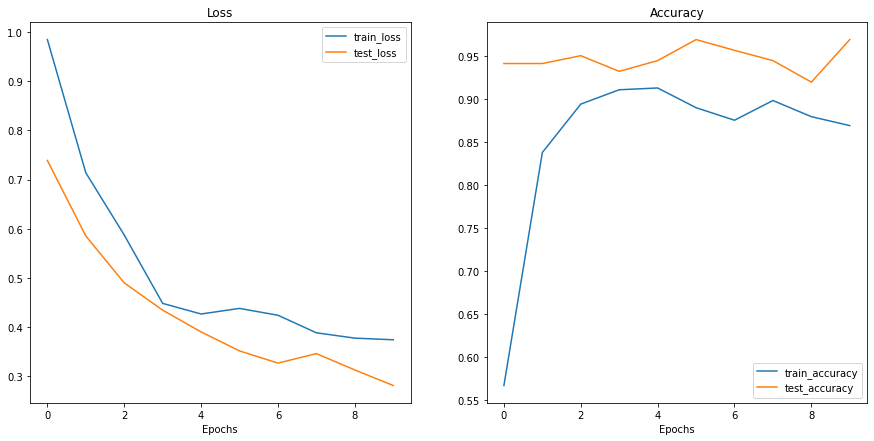

In [ ]:
plot_loss_curves(effnetb2_results)

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,target_dir="models",model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

pretrained_effnetb2_model_size=Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size //  (1024*1024)
pretrained_effnetb2_model_size

29

In [ ]:
effnetb2_total_params=sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
effnetb2_stats={"test_loss":effnetb2_results["test_loss"][-1],
                "test_acc":effnetb2_results["test_acc"][-1],
                "number_of_parameters":effnetb2_total_params,
                "model_size_mb":pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28086441457271577,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size_mb': 29}

In [ ]:
vit=torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,seed:int=42):
  weights=torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad=False
  torch.manual_seed(42)
  model.heads=nn.Sequential(nn.Linear(in_features=768,out_features=num_classes,bias=True))
  return model,transforms

In [ ]:
vit,vit_tranforms=create_vit_model()
vit_tranforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
from going_modular.going_modular import data_setup

train_dataloader_vit,test_dataloader_vit,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                                   test_dir=test_dir,
                                                                                   transform=vit_tranforms,
                                                                                   batch_size=32)

In [ ]:
len(train_dataloader_vit),len(test_dataloader_vit),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [ ]:
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=vit.parameters(),lr=1e-3)
loss_fn=torch.nn.CrossEntropyLoss()

set_seeds()

vit_results=engine.train(model=vit,train_dataloader=train_dataloader_vit,test_dataloader=test_dataloader_vit,
                         epochs=10,optimizer=optimizer,loss_fn=loss_fn,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


In [ ]:
!nvidia-smi

Fri Jan 27 11:36:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    38W /  70W |   1954MiB / 15360MiB |     80%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

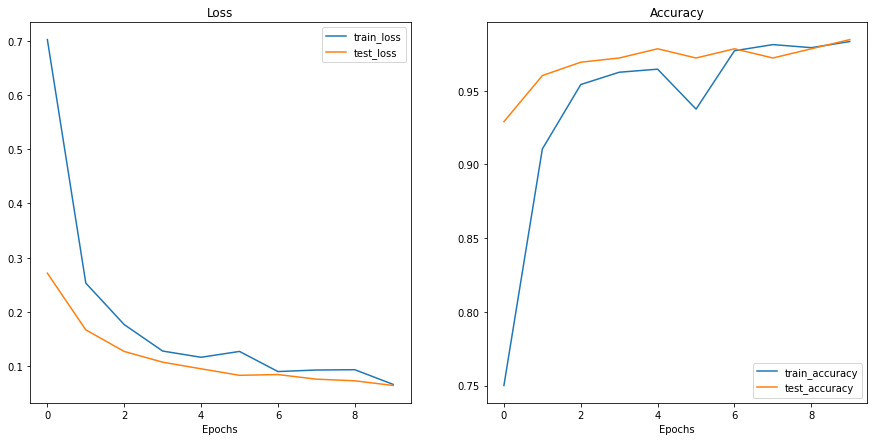

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

In [ ]:
from going_modular.going_modular import utils
utils.save_model(model=vit,target_dir="models",model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path
pretrained_vit_model_size=Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size//(1024*1024)
pretrained_vit_model_size

327

In [ ]:
pretrained_effnetb2_model_size,pretrained_vit_model_size

(29, 327)

In [ ]:
vit_total_params=sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
vit_stats={"test_loss":vit_results["test_loss"][-1],
           "test_acc":vit_results["test_acc"][-1],
           "number_of_parameters":vit_total_params,
           "model_size_mb":pretrained_vit_model_size}

In [ ]:
vit_stats

{'test_loss': 0.06418211054988206,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size_mb': 327}

In [ ]:
from pathlib import Path
test_data_paths=list(Path(test_dir).glob("*/*.jpg"))

In [ ]:
test_data_paths[0].parent.stem

'pizza'

In [ ]:
import pathlib
import torch
from PIL import Image
from typing import List,Dict
from timeit import default_timer
from tqdm.auto import tqdm

def pred_and_store(paths:List[pathlib.Path],
                   model:torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names:List[str],
                   device:str="cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  pred_list=[]

  for path in tqdm(paths):
    pred_dict={}
    pred_dict["image_path"]=path
    class_name=path.parent.stem
    pred_dict["class_name"]=class_name
    start_time=default_timer()
    img=Image.open(path)
    transformed_image=transform(img).unsqueeze(0).to(device)
    model=model.to(device)
    model.eval()
    with torch.inference_mode():
      pred_logit=model(transformed_image)
      pred_prob=torch.softmax(pred_logit,dim=1)
      print(pred_prob.shape)
      pred_label=torch.argmax(pred_prob,dim=1)
      pred_class=class_names[pred_label.cpu()]

      pred_dict["pred_prob"]=round(pred_prob.unsqueeze(0).max().cpu().item(),4)
      pred_dict["pred_class"]=pred_class
      end_time=default_timer()
      pred_dict["time_for_pred"]=round(end_time-start_time,4)
    pred_dict["correct"]=class_name==pred_class
    pred_list.append(pred_dict)
  return pred_list

In [ ]:
effnet_b2_test_pred_dicts=pred_and_store(paths=test_data_paths,model=effnetb2,
                                         transform=effnetb2_transforms,class_names=class_names,
                                         device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([

In [ ]:
import pandas as pd
effnetb2_test_pred_df=pd.DataFrame(effnet_b2_test_pred_dicts)
effnetb2_test_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.4134,pizza,0.2737,True
1,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.9147,pizza,0.0934,True
2,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9789,pizza,0.0908,True
3,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9676,pizza,0.1011,True
4,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9190,pizza,0.0914,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.8459,sushi,0.0952,True
146,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.8302,sushi,0.0952,True
147,data/pizza_steak_sushi_20_percent/test/sushi/9...,sushi,0.7648,sushi,0.1077,True
148,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.8369,sushi,0.0976,True


In [ ]:
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

In [ ]:
effnetb2_average_time_per_pred=round(effnetb2_test_pred_df.time_for_pred.mean(),4)
effnetb2_average_time_per_pred

0.0969

In [ ]:
vit_test_pred_dicts=pred_and_store(paths=test_data_paths,model=vit,transform=vit_tranforms,
                                   class_names=class_names,device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([

In [ ]:
vit_test_pred_df=pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [ ]:
vit_average_time_pre_pred=round(vit_test_pred_df.time_for_pred.mean(),4)
vit_average_time_pre_pred

0.3948

In [ ]:
vit_stats["time_for_pred_cpu"]=vit_average_time_pre_pred
effnetb2_stats["time_for_pred_cpu"]=effnetb2_average_time_per_pred

In [ ]:
vit_stats,effnetb2_stats

({'test_loss': 0.06418211054988206,
  'test_acc': 0.984659090909091,
  'number_of_parameters': 85800963,
  'model_size_mb': 327,
  'time_for_pred_cpu': 0.3948},
 {'test_loss': 0.28086441457271577,
  'test_acc': 0.96875,
  'number_of_parameters': 7705221,
  'model_size_mb': 29,
  'time_for_pred_cpu': 0.0969})

In [ ]:
df=pd.DataFrame([effnetb2_stats,vit_stats])
df["model"]=["EffNetB2","ViT"]
df["test_acc"]=round(df["test_acc"]*100,2)
df

,test_loss,test_acc,number_of_parameters,model_size_mb,time_for_pred_cpu,model
0,0.280864,96.88,7705221,29,0.0969,EffNetB2
1,0.064182,98.47,85800963,327,0.3948,ViT


In [ ]:
pd.DataFrame(df.set_index("model").loc["ViT"]/df.set_index("model").loc["EffNetB2"],columns=(["ViT to EffnetB2 ratios"])).T

,test_loss,test_acc,number_of_parameters,model_size_mb,time_for_pred_cpu
ViT to EffnetB2 ratios,0.228516,1.016412,11.135432,11.275862,4.074303


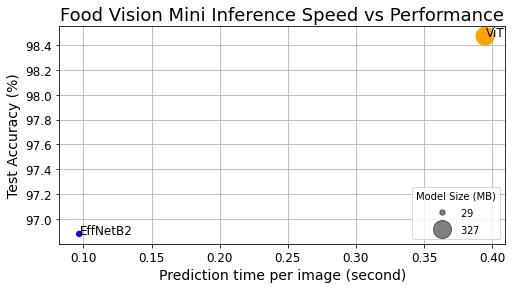

In [ ]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(8,4))
scatter=ax.scatter(data=df,x="time_for_pred_cpu",y="test_acc",c=["blue","orange"],s="model_size_mb")
ax.set_title("Food Vision Mini Inference Speed vs Performance",fontsize=18)
ax.set_xlabel("Prediction time per image (second)",fontsize=14)
ax.set_ylabel("Test Accuracy (%)",fontsize=14)
ax.tick_params(axis="both",labelsize=12)
ax.grid(True)

for index,row in df.iterrows():
  ax.annotate(s=row["model"],xy=(row["time_for_pred_cpu"]+0.0006,row["test_acc"]+0.0004),size=12)

handles,labels=scatter.legend_elements(prop="sizes",alpha=0.5)
model_size_legend=ax.legend(handles,labels,loc="lower right",title="Model Size (MB)")

plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

In [ ]:
import matplotlib
matplotlib.__version__

'3.2.2'

In [ ]:
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple,Dict,List

def predict(img) -> Tuple[Dict,float]:
  start_time=default_timer()
  img=effnetb2_transforms(img).unsqueeze(0)
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs=torch.softmax(effnetb2(img),dim=1)
    pred_labels_and_probs={class_names[i]:float(pred_probs[0][i]) for i in range(len(class_names))}
    end_time=default_timer()
    pred_time=round(end_time-start_time,4)
  return pred_labels_and_probs,pred_time

In [ ]:
import random
from PIL import Image

test_data_paths=list(Path(test_dir).glob("*/*.jpg"))
random_image_path=random.sample(test_data_paths,k=1)[0]
random_image_path

PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/715227.jpg')

In [ ]:
image=Image.open(random_image_path)
pred_dict,pred_time=predict(image)
pred_dict,pred_time

({'pizza': 0.17176435887813568,
  'steak': 0.09661638736724854,
  'sushi': 0.7316192388534546},
 0.5637)

In [ ]:
sample_list=[[str(filepath)] for filepath in random.sample(test_data_paths,k=3)]
sample_list

[['data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/3886015.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2756200.jpg']]

In [ ]:
import gradio as gr

title="FoodVision Mini ⭐🌙"
description="An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article="Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) "

demo=gr.Interface(fn=predict,inputs=gr.Image(type="pil"),
                  outputs=[gr.Label(num_top_classes=3,label="Predictions"),gr.Number(label="Prediction Time (s)")],
                  examples=sample_list,title=title,description=description,article=article)
demo.launch(debug=False,share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://69036ce9-4b85-41c1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [ ]:
import shutil
from pathlib import Path
foodvision_mini_demo_path=Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,exist_ok=True)

!ls demos/foodvision_mini/

In [ ]:
import shutil
from pathlib import Path

foodvision_mini_examples_path=foodvision_mini_demo_path/"examples"
foodvision_mini_examples_path.mkdir(parents=True,exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
  destination=foodvision_mini_examples_path/example.name
  shutil.copy2(src=example,dst=destination)

In [ ]:
import os
example_list=[["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/592799.jpg'], ['examples/2582289.jpg']]

In [ ]:
import shutil
effnetb2_foodvision_mini_model_path="models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
effnetb2_foodvision_mini_model_destination=foodvision_mini_demo_path/effnetb2_foodvision_mini_model_path.split("/")[1]
effnetb2_foodvision_mini_model_destination

PosixPath('demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth')

In [ ]:
try:
  print(f"attempting to move {effnetb2_foodvision_mini_model_destination} to {effnetb2_foodvision_mini_model_destination}")
  shutil.move(src=effnetb2_foodvision_mini_model_path,dst=effnetb2_foodvision_mini_model_destination)
  print("Move successful")
except:
  print(f"No model found at {effnetb2_foodvision_mini_model_path}")
  print(f"Model exists at {effnetb2_foodvision_mini_model_destination}")

attempting to move demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
Move successful


In [ ]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torchvision import transforms
from torch import nn

def create_effnetb2_model(num_classes:int=3,seed:int=42):
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad=False
  torch.manual_seed(seed)
  model.classifier=nn.Sequential(nn.Dropout(p=0.3,inplace=True),
                                 nn.Linear(in_features=1408,out_features=num_classes))
  return model,transforms

Writing demos/foodvision_mini/model.py


In [ ]:
from demos.foodvision_mini import model
effnetb2_model,effnetb2_transforms=model.create_effnetb2_model()
effnetb2_model,effnetb2_transforms

(EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): SiLU(inplace=True)
           )
           (1): SqueezeExcitation(
             (avgpool): AdaptiveAvgPool2d(output_size=1)
             (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (activation): SiLU(inplace=True)
             (scale_activation): Sigmoid()
           )
          

In [ ]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch
from model import create_effnetb2_model

from timeit import default_timer as timer
from typing import Tuple,Dict,List

class_names=["pizza","steak","sushi"]
effnetb2,effnetb2_transforms=create_effnetb2_model(num_classes=len(class_names))
effnetb2.load_state_dict(torch.load(f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
                                    map_location=torch.device("cpu")))

def predict(img) -> Tuple[Dict,float]:
  start_time=default_timer()
  img=effnetb2_transforms(img).unsqueeze(0)
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs=torch.softmax(effnetb2(img),dim=1)
    pred_labels_and_probs={class_names[i]:float(pred_probs[0][i]) for i in range(len(class_names))}
    end_time=default_timer()
    pred_time=round(end_time-start_time,4)
  return pred_labels_and_probs,pred_time

example_list=[["examples/" + example] for example in os.listdir("examples")]

title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"), 
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), 
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

demo.launch()

Writing demos/foodvision_mini/app.py


In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.13.1
torchvision==0.14.1
gradio==3.16.2

Writing demos/foodvision_mini/requirements.txt


In [ ]:
torch.__version__,torchvision.__version__,gr.__version__

('1.13.1+cu116', '0.14.1+cu116', '3.16.2')

In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
__pycache__
requirements.txt


In [ ]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x ".pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 53%)
  adding: examples/ (stored 0%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: model.py (deflated 47%)
  adding: requirements.txt (deflated 6%)


In [ ]:
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print("Please download the file manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from IPython.display import IFrame
IFrame(src="https://rajy4190-foodvision-mini.hf.space", width=900, height=750)

In [ ]:
effnetb2_food101,effnetb2_transforms=create_effnetb2_model(num_classes=101)


In [ ]:
summary(effnetb2_food101, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
food_101_train_transforms=transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                         effnetb2_transforms])

In [ ]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
from torchvision import datasets

In [ ]:
from pathlib import Path
data_dir=Path("data")
train_data=datasets.Food101(root=data_dir,split="train",transform=food_101_train_transforms,download=True)
test_data=datasets.Food101(root=data_dir,split="test",transform=effnetb2_transforms,download=True)

  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting data/food-101.tar.gz to data


In [ ]:
food101_class_names=train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,split_size:float=0.2,seed:int=42):
  length_1=int(len(dataset)*split_size)
  length_2=len(dataset)-length_1
  random_split_1,random_split_2=torch.utils.data.random_split(dataset,lengths=[length_1,length_2],
                                                              generator=torch.manual_seed(seed))
  return random_split_1,random_split_2

In [ ]:
train_data_food101_20_percent,_=split_dataset(dataset=train_data,split_size=0.2)

test_data_food101_20_percent,_=split_dataset(dataset=test_data,split_size=0.2)

In [ ]:
len(train_data_food101_20_percent),len(test_data_food101_20_percent)

(15150, 5050)

In [ ]:
import torch

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
train_dataloader_food101_20_percent=torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,batch_size=BATCH_SIZE,
                                                                shuffle=True,num_workers=NUM_WORKERS)
test_dataloader_food101_20_percent=torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,batch_size=BATCH_SIZE,
                                                               shuffle=False,num_workers=NUM_WORKERS)

In [ ]:
len(train_dataloader_food101_20_percent),len(test_dataloader_food101_20_percent)

(474, 158)

In [ ]:
from going_modular.going_modular import engine

optimizer=torch.optim.Adam(params=effnetb2_food101.parameters(),lr=1e-3)
loss_fn=torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()

effnetb2_food101_results=engine.train(model=effnetb2_food101,train_dataloader=train_dataloader_food101_20_percent,
                                      test_dataloader=test_dataloader_food101_20_percent,optimizer=optimizer,
                                      loss_fn=loss_fn,epochs=5,device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6417 | train_acc: 0.2804 | test_loss: 2.7815 | test_acc: 0.4915
Epoch: 2 | train_loss: 2.8621 | train_acc: 0.4410 | test_loss: 2.4731 | test_acc: 0.5332
Epoch: 3 | train_loss: 2.6545 | train_acc: 0.4861 | test_loss: 2.3638 | test_acc: 0.5566
Epoch: 4 | train_loss: 2.5437 | train_acc: 0.5140 | test_loss: 2.3022 | test_acc: 0.5735
Epoch: 5 | train_loss: 2.4955 | train_acc: 0.5252 | test_loss: 2.2800 | test_acc: 0.5802


[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


<All keys matched successfully>

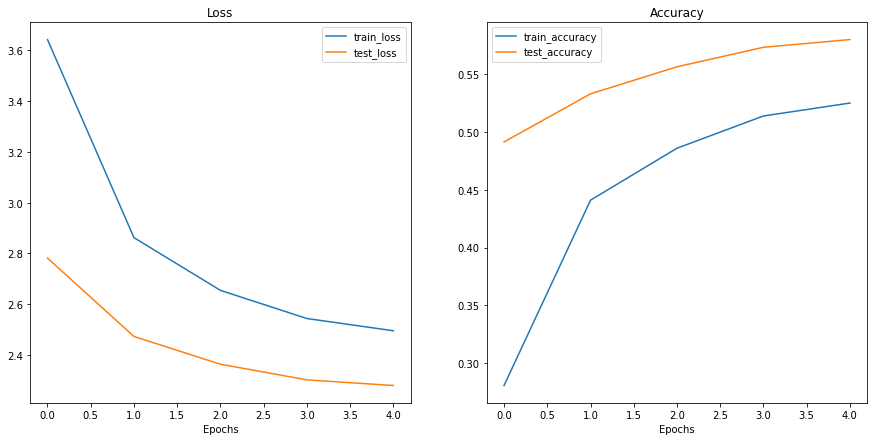

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

from going_modular.going_modular import utils
effnetb2_food101_model_path="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

utils.save_model(model=effnetb2_food101,target_dir="models/",model_name=effnetb2_food101_model_path)

loaded_effnetb2_food101,effnetb2_transforms=create_effnetb2_model(num_classes=101)

loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

In [ ]:
from pathlib import Path

pretrained_effnetb2_food101_model_size=Path("models",effnetb2_food101_model_path).stat().st_size // (1024*1024)
pretrained_effnetb2_food101_model_size

30

In [ ]:
from pathlib import Path
foodvision_big_demo_path=Path("demos/foodvision_big")
foodvision_big_demo_path.mkdir(parents=True,exist_ok=True)

(foodvision_big_demo_path/"examples").mkdir(parents=True,exist_ok=True)

In [ ]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpeg

--2023-01-27 13:18:16--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg [following]
--2023-01-27 13:18:17--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.04s   

2023-01-27 13:18:17 (61.1 MB/s) - ‘04-pizza-dad.jpeg’ sa

In [ ]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

In [ ]:
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
foodvision_big_class_names_path=foodvision_big_demo_path/"class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [ ]:
with open(foodvision_big_class_names_path,"w") as f:
  f.write("\n".join(food101_class_names))

In [ ]:
with open(foodvision_big_class_names_path,"r") as f:
  food101_class_names_loaded=[food.strip() for food in f.readlines()]

In [ ]:
%%writefile demos/foodvision_big/model.py

import torch
import torchvision
from torchvision import transforms
from torch import nn

def create_effnetb2_model(num_classes:int=3,seed:int=42):
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad=False
  torch.manual_seed(seed)
  model.classifier=nn.Sequential(nn.Dropout(p=0.3,inplace=True),
                                 nn.Linear(in_features=1408,out_features=num_classes))
  return model,transforms

Writing demos/foodvision_big/model.py


In [ ]:
%%writefile demos/foodvision_big/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple,Dict

with open("class_names.txt","r") as f:
  class_names=[food_name.strip() for food_name in f.readlines()]

effnetb2,effnetb2_transforms=create_effnetb2_model(num_classes=len(class_names))
effnetb2.load_state_dict(torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
                                    map_location=torch.device("cpu")))

def predict(img) -> Tuple[Dict,float]:
  start_time=timer()
  img=effnetb2_transforms(img).unsqueeze(0)
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs=torch.softmax(effnetb2(img),dim=1)
    pred_labels_and_probs={class_names[i]:float(pred_probs[0][i]) for i in range(len(class_names))}
    end_time=timer()
    pred_time=round(end_time-start_time,4)
  return pred_labels_and_probs,pred_time

example_list=[["examples/" + example] for example in os.listdir("examples")]

title = "FoodVision Big 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify 101 images from the food101 dataset"
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#114-turning-our-foodvision-big-gradio-app-into-a-python-script-apppy)."

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type="pil"), 
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), 
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

demo.launch()

Writing demos/foodvision_big/app.py


In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.13.1
torchvision==0.14.1
gradio==3.16.2

Writing demos/foodvision_big/requirements.txt


In [ ]:
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 52%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpeg (deflated 0%)
  adding: model.py (deflated 47%)
  adding: requirements.txt (deflated 6%)


In [ ]:
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print("Please download the file manually")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://rajy4190-foodvision-big.hf.space

In [ ]:
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an iFrame
IFrame(src="https://rajy4190-foodvision-big.hf.space", width=900, height=750)